In [3]:
#!activate PythonGPU
import numpy as np
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

def simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew):
    #The multivariate skew normal number generator
    def rng(mu, sigma, skew, n=1):
        k = len(mu)
        if not (k == len(sigma) and k ==len(skew)): 
            raise Exception("Mu, Sigma and Skew should be same length")

        data = np.zeros((int(n),k))

        for i in range(k):
            data[:,i] = skewnorm.rvs(skew[i], loc=mu[i], scale=sigma[i], size=int(n)) 

        return data
    
    if(np.sum(classes) != 1):
        raise Exception("Classes dont sum up to 1")
        
    n_classes = len(classes)
    sigma = np.random.randint(1,max_sigma,n_vars)
    skew = np.random.randint(-max_skew,max_skew,n_vars)
    mu =  np.random.randint(-max_mu, max_mu, (n_classes, n_vars))
    
    n_obs_class = np.round(np.dot(classes,n))
    
    data = np.zeros((int(np.sum(n_obs_class)),n_vars+1))
    for i in range(n_classes):
        #calculate indexes
        start = int(np.sum(n_obs_class[0:i]))
        end = int(np.sum(n_obs_class[0:i+1]))
        
        #set the data
        data[start:end,0] = i
        data[start:end,1:] = rng(mu[i,:], sigma, skew, n_obs_class[i])
        
    X = data[:,1:]
    y = data[:,0]
    
    columns = ["x"+str(x) for x in range(n_vars + 1)]
    columns[0] = "class"
    
    df = pd.DataFrame(data,columns=columns)
    df["class"] = df["class"].astype(int)
    return X,y, df



#parameters
classes = [0.1, 0.3, 0.5, 0.1] #percentages
n_vars = 7
n = 10000
max_mu = 4
max_sigma = 30
max_skew = 10
np.random.seed(12345)

#generate data
X,y, df = simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew)

display(df.groupby(["class"]).agg(["count", "mean", "var"]))

#make train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42,
    stratify=y)


accuracies = pd.DataFrame(columns=['method', 'accuracy', 'predictions'])

x1                        x2                         x3            \
      count      mean       var count      mean        var count      mean   
class                                                                        
0      1000 -3.294734  3.143400  1000  5.749281  12.891755  1000 -0.436298   
1      3000 -3.351363  3.319229  3000  7.744481  13.336809  3000  4.532960   
2      5000 -1.399495  3.384245  5000  1.827524  13.227926  5000  0.609200   
3      1000 -3.471339  3.533590  1000  4.756253  12.932488  1000  1.559189   

                   x4  ...               x5                          x6  \
            var count  ...        var count       mean        var count   
class                  ...                                                
0      1.537296  1000  ...  17.083661  1000   5.898511  37.513984  1000   
1      1.559789  3000  ...  16.856935  3000   4.106528  37.066571  3000   
2      1.710263  5000  ...  17.310195  5000   7.984402  38.211944  5000   
3      1.530928  1000  ...  17.158728  1000  10.744529  34.887650  1000   

                              x7                      
           mean        var count      mean       var  
class                                                 
0      6.850886  13.618705  1000  1.329985  6.086574  
1      7.759025  13.633589  3000  1.301245  6.635162  
2      0.670571  13.281096  5000  1.283414  6.197588  
3      7.839408  13.647387  1000 -2.633394  6.442011  

[4 rows x 21 columns]

LDA Test accuracy 0.9109090909090909
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.77       330
         1.0       0.93      0.98      0.95       990
         2.0       0.94      0.94      0.94      1650
         3.0       0.79      0.74      0.76       330

    accuracy                           0.91      3300
   macro avg       0.87      0.85      0.86      3300
weighted avg       0.91      0.91      0.91      3300



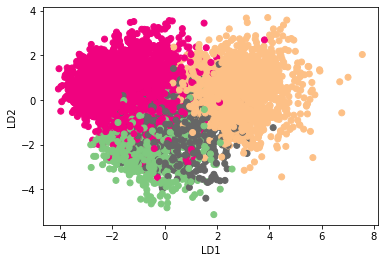

In [4]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=classes)
X_lda = lda.fit_transform(X_train, y_train)



lda_pred = lda.predict(X_test)
lda_acc = accuracy_score(y_test, lda_pred)
print("LDA Test accuracy "+ str(lda_acc))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, lda_pred))

accuracies = accuracies.append({"method": "LDA", 
                   "accuracy":lda_acc, 
                   "predictions":lda_pred}, 
                    ignore_index=True)



plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_train,
    cmap='Accent',
#      alpha=0.7,
#      edgecolors='grey'
)

In [5]:
#Quadratic
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(priors=classes)
X_qda = qda.fit(X_train, y_train)



qda_pred = qda.predict(X_test)
qda_acc = accuracy_score(y_test, qda_pred)
print("QDA Test accuracy "+ str(qda_acc))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, qda_pred))

accuracies = accuracies.append({"method": "QDA", 
                   "accuracy":qda_acc, 
                   "predictions":qda_pred}, 
                    ignore_index=True)

QDA Test accuracy 0.9109090909090909
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       330
         1.0       0.93      0.98      0.95       990
         2.0       0.94      0.94      0.94      1650
         3.0       0.79      0.72      0.75       330

    accuracy                           0.91      3300
   macro avg       0.87      0.84      0.86      3300
weighted avg       0.91      0.91      0.91      3300



In [6]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)


clf_pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, clf_pred)
print("Logistic Test accuracy "+ str(clf_acc))

accuracies = accuracies.append({"method": "Logit", 
                   "accuracy":clf_acc, 
                   "predictions":clf_pred}, 
                    ignore_index=True)

# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, clf_pred))

# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.scatter(
#     clf[:,0],
#     clf[:,1],
#     c=y_train,
#     cmap='Accent',
# #      alpha=0.7,
# #      edgecolors='grey'
# )

Logistic Test accuracy 0.9112121212121213
              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78       330
         1.0       0.94      0.97      0.95       990
         2.0       0.94      0.95      0.94      1650
         3.0       0.79      0.72      0.75       330

    accuracy                           0.91      3300
   macro avg       0.87      0.85      0.86      3300
weighted avg       0.91      0.91      0.91      3300



C:\Users\Sophia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [23]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, clf_pred)

print("K-NN Test accuracy "+ str(knn_acc))

print(classification_report(y_test, knn_pred))

#confusion_matrix(y_test, y_pred)

accuracies = accuracies.append({"method": "KNN", 
                   "accuracy":knn_acc, 
                   "predictions":knn_pred}, 
                    ignore_index=True)

K-NN Test accuracy 0.9112121212121213
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.70       330
         1.0       0.89      0.97      0.93       990
         2.0       0.94      0.93      0.93      1650
         3.0       0.74      0.62      0.67       330

    accuracy                           0.89      3300
   macro avg       0.82      0.80      0.81      3300
weighted avg       0.88      0.89      0.88      3300



In [24]:
#Naive bayes
from sklearn.naive_bayes import GaussianNB



print("Naive Bayes Test accuracy "+ str(NB_acc))

print(metrics.classification_report(y_test, NB_pred))

accuracies = accuracies.append({"method": "NB", 
                   "accuracy":NB_acc, 
                   "predictions":NB_pred}, 
                    ignore_index=True)

Naive Bayes Test accuracy 0.9106060606060606
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       330
         1.0       0.93      0.98      0.95       990
         2.0       0.94      0.94      0.94      1650
         3.0       0.79      0.72      0.75       330

    accuracy                           0.91      3300
   macro avg       0.87      0.85      0.86      3300
weighted avg       0.91      0.91      0.91      3300



In [ ]:
#SVM

In [17]:
#Neural Network
from tensorflow.keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(n_vars,), name='obs')
x = layers.Dense(40, activation='relu')(inputs)
x = layers.Dense(40, activation='relu')(x)
x = layers.Dense(40, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Dataset')

display(model.summary())


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

accuracies = accuracies.append({"method": "Neural Net", 
                   "accuracy": test_scores[1], 
                   "predictions":clf_pred}, 
                    ignore_index=True)

ModuleNotFoundError: No module named 'tensorflow'

In [25]:
accuracies

,method,accuracy,predictions
0,LDA,0.910909,"[3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, ..."
1,QDA,0.910909,"[3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, ..."
2,Logit,0.911212,"[3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, ..."
3,KNN,0.911212,"[3.0, 2.0, 1.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, ..."
4,NB,0.910606,"[3.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, ..."
